<a href="https://colab.research.google.com/github/Cycyplay/M2_DeepLearning_Classification/blob/main/Deep_Learning_Projet_Classification_Version_R%C3%A9seau_Existant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet M2 Deep Learning Classification 
## Version Réseau Préentrainé


J'ai décidé d'utiliser un réseau convnet entrainé sur la base d'image ImageNet,
base qui represente de nombreuses catégories, d'objets du quotidien aux animaux etc.

**L'idée : classer les différents courants artistiques par la présence de différents objets dans les oeuvres**

À faire expliquer pourquoi j'ai utilisé VGG16 plutot que les autres avec le tableau voir doc KERAS


# Test d'un réseau existant ImageNet pour la classification d'objet présent sur les oeuvres

In [3]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline 

from google.colab import drive
drive.mount('/content/drive')


x_test = np.load('./drive/MyDrive/DeepLearning_Dataset/x_test.npy')
x_train = np.load('./drive/MyDrive/DeepLearning_Dataset/x_train.npy')
y_test = np.load('./drive/MyDrive/DeepLearning_Dataset/y_test.npy')
y_train = np.load('./drive/MyDrive/DeepLearning_Dataset/y_train.npy')

Mounted at /content/drive


In [4]:
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
from keras import models
from keras.models import Model
from keras.layers import Dense

In [5]:
image = cv2.resize(x_test[1000], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

model = VGG16(weights="imagenet")
preds = model.predict(image)

1/1 [==============================] - 8s 8s/step


35363/35363 [==============================] - 0s 0us/step
1. breastplate: 4.65%
2. Sussex_spaniel: 3.69%
3. Welsh_springer_spaniel: 3.52%
4. cuirass: 3.15%
5. English_foxhound: 2.72%


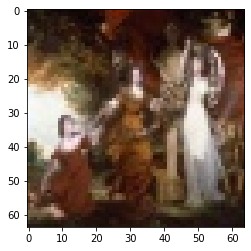

In [6]:
P = decode_predictions(preds)
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
	print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))
 
plt.imshow(x_test[1000], interpolation='nearest')
plt.show()

# Fine Tuning

In [7]:
import tensorflow as tf
tensor_x_test = tf.constant(x_test)
tensor_y_test = tf.constant(y_test)
tensor_x_train = tf.constant(x_train)
tensor_y_train = tf.constant(y_train)

In [14]:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))


x = base_model.output
x = keras.layers.Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(tensor_x_train, tensor_y_train, verbose=True, batch_size=128, epochs=20, validation_data=(tensor_x_test, tensor_y_test))

Epoch 1/20
54/54 [==============================] - 5s 55ms/step - loss: 5.3628 - accuracy: 0.3051 - val_loss: 2.0853 - val_accuracy: 0.3063
Epoch 2/20
54/54 [==============================] - 3s 48ms/step - loss: 1.5679 - accuracy: 0.4513 - val_loss: 1.9878 - val_accuracy: 0.3880
Epoch 3/20
54/54 [==============================] - 3s 51ms/step - loss: 1.1551 - accuracy: 0.5822 - val_loss: 1.9989 - val_accuracy: 0.4103
Epoch 4/20
54/54 [==============================] - 3s 52ms/step - loss: 0.8793 - accuracy: 0.6746 - val_loss: 2.0664 - val_accuracy: 0.4280
Epoch 5/20
54/54 [==============================] - 3s 51ms/step - loss: 0.6674 - accuracy: 0.7553 - val_loss: 2.1465 - val_accuracy: 0.4474
Epoch 6/20
54/54 [==============================] - 3s 51ms/step - loss: 0.5086 - accuracy: 0.8213 - val_loss: 2.2694 - val_accuracy: 0.4474
Epoch 7/20
54/54 [==============================] - 3s 51ms/step - loss: 0.3861 - accuracy: 0.8702 - val_loss: 2.3739 - val_accuracy: 0.4503
Epoch 8/20
54

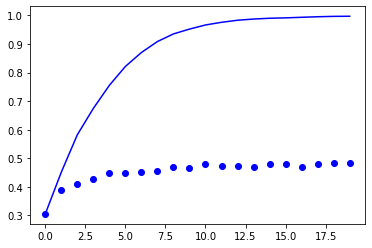

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], "b")
plt.plot(history.history["val_accuracy"], "bo")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], "b")

## With data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape=(64, 64, 3))

In [20]:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))

# Data augmentation
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inputs, outputs=predictions)

# first: train only the top layers
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(tensor_x_train, tensor_y_train, verbose=True, batch_size=128, epochs=20, validation_data=(tensor_x_test, tensor_y_test))

Epoch 1/20


54/54 [==============================] - 77s 1s/step - loss: 5.7751 - accuracy: 0.2677 - val_loss: 2.3725 - val_accuracy: 0.2728
Epoch 2/20
54/54 [==============================] - 62s 1s/step - loss: 1.9723 - accuracy: 0.3095 - val_loss: 2.0891 - val_accuracy: 0.3451
Epoch 3/20
54/54 [==============================] - 61s 1s/step - loss: 1.8144 - accuracy: 0.3715 - val_loss: 2.0193 - val_accuracy: 0.3610
Epoch 4/20
54/54 [==============================] - 62s 1s/step - loss: 1.7352 - accuracy: 0.4004 - val_loss: 1.9662 - val_accuracy: 0.3727
Epoch 5/20
54/54 [==============================] - 62s 1s/step - loss: 1.6288 - accuracy: 0.4282 - val_loss: 1.9603 - val_accuracy: 0.3851
Epoch 6/20
54/54 [==============================] - 61s 1s/step - loss: 1.5504 - accuracy: 0.4519 - val_loss: 1.8820 - val_accuracy: 0.4180
Epoch 7/20
54/54 [==============================] - 60s 1s/step - loss: 1.4931 - accuracy: 0.4727 - val_loss: 1.8573 - val_accuracy: 0.4303
Epoch 8/20
54/54 [=============

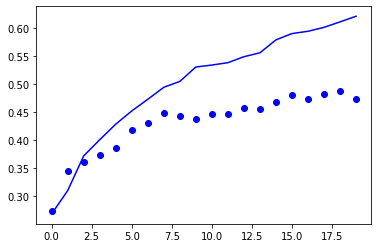

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], "b")
plt.plot(history.history["val_accuracy"], "bo")


In [31]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

base_model.trainable = True
for layer in base_model.layers[:-4]:
 layer.trainable = False

model.compile(loss="SparseCategoricalCrossentropy",
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
  metrics=["accuracy"])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
history = model.fit(tensor_x_train, tensor_y_train, verbose=True, batch_size=128, epochs=30, validation_data=(tensor_x_test, tensor_y_test))

0 input_9
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/30


54/54 [==============================] - 68s 1s/step - loss: 1.0060 - accuracy: 0.6389 - val_loss: 1.8565 - val_accuracy: 0.4774
Epoch 2/30
54/54 [==============================] - 60s 1s/step - loss: 0.9488 - accuracy: 0.6537 - val_loss: 1.8836 - val_accuracy: 0.4950
Epoch 3/30
54/54 [==============================] - 61s 1s/step - loss: 0.9125 - accuracy: 0.6689 - val_loss: 1.9303 - val_accuracy: 0.4885
Epoch 4/30
54/54 [==============================] - 60s 1s/step - loss: 0.8874 - accuracy: 0.6756 - val_loss: 1.8751 - val_accuracy: 0.4997
Epoch 5/30
54/54 [==============================] - 62s 1s/step - loss: 0.8854 - accuracy: 0.6817 - val_loss: 1.8978 - val_accuracy: 0.5003
Epoch 6/30
54/54 [==============================] - 60s 1s/step - loss: 0.8381 - accuracy: 0.6933 - val_loss: 1.9073 - val_accuracy: 0.5044
Epoch 7/30
54/54 [==============================] - 61s 1s/step - loss: 0.8360 - accuracy: 0.6952 - val_loss: 1.9367 - val_accuracy: 0.5003
Epoch 8/30
54/54 [=============

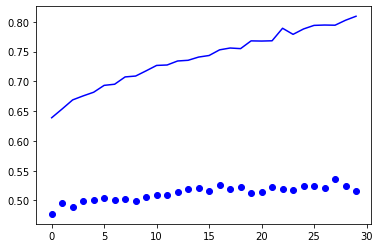

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], "b")
plt.plot(history.history["val_accuracy"], "bo")
 

In [34]:
# Save model
from keras.models import model_from_json
from pathlib import Path

model_structure = model.to_json()
f = Path("drive/MyDrive/DeepLearning_Dataset/model_1_pretrained_structure.json")
f.write_text(model_structure)

model.save_weights("drive/MyDrive/DeepLearning_Dataset/model_1_pretrained_weights.h5")

# Model 2

In [36]:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))

# Data augmentation
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = Dense(9, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=inputs, outputs=predictions)

# first: train only the top layers
# i.e. freeze all convolutional VGG16 layers
base_model.trainable = False

model.compile(optimizer='rmsprop', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(tensor_x_train, tensor_y_train, verbose=True, batch_size=128, epochs=20, validation_data=(tensor_x_test, tensor_y_test))

Epoch 1/20


54/54 [==============================] - 122s 1s/step - loss: 10.6846 - accuracy: 0.1630 - val_loss: 2.9313 - val_accuracy: 0.1928
Epoch 2/20
54/54 [==============================] - 59s 1s/step - loss: 2.4271 - accuracy: 0.1594 - val_loss: 2.2872 - val_accuracy: 0.2011
Epoch 3/20
54/54 [==============================] - 59s 1s/step - loss: 2.2128 - accuracy: 0.1746 - val_loss: 2.1541 - val_accuracy: 0.2346
Epoch 4/20
54/54 [==============================] - 65s 1s/step - loss: 2.1515 - accuracy: 0.2041 - val_loss: 2.0739 - val_accuracy: 0.2928
Epoch 5/20
54/54 [==============================] - 61s 1s/step - loss: 2.0860 - accuracy: 0.2387 - val_loss: 1.9928 - val_accuracy: 0.3345
Epoch 6/20
54/54 [==============================] - 59s 1s/step - loss: 2.0489 - accuracy: 0.2423 - val_loss: 1.9577 - val_accuracy: 0.3557
Epoch 7/20
54/54 [==============================] - 61s 1s/step - loss: 2.0194 - accuracy: 0.2526 - val_loss: 1.8983 - val_accuracy: 0.3480
Epoch 8/20
54/54 [===========

54/54 [==============================] - 2s 20ms/step - loss: 1.7686 - accuracy: 0.3974
Test accuracy: 0.3974132835865021
Test loss: 1.7686123847961426


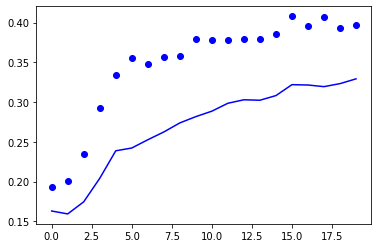

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], "b")
plt.plot(history.history["val_accuracy"], "bo")

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))
print("Test loss: {}".format(test_loss))

In [41]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
 layer.trainable = False

model.compile(loss="SparseCategoricalCrossentropy",
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
  metrics=["accuracy"])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
history = model.fit(tensor_x_train, tensor_y_train, verbose=True, batch_size=128, epochs=50, validation_data=(tensor_x_test, tensor_y_test))

Epoch 1/50


54/54 [==============================] - 70s 1s/step - loss: 1.7662 - accuracy: 0.3425 - val_loss: 1.7246 - val_accuracy: 0.4015
Epoch 2/50
54/54 [==============================] - 61s 1s/step - loss: 1.7527 - accuracy: 0.3477 - val_loss: 1.7261 - val_accuracy: 0.4145
Epoch 3/50
54/54 [==============================] - 59s 1s/step - loss: 1.7391 - accuracy: 0.3500 - val_loss: 1.6883 - val_accuracy: 0.4092
Epoch 4/50
54/54 [==============================] - 61s 1s/step - loss: 1.7143 - accuracy: 0.3583 - val_loss: 1.7124 - val_accuracy: 0.4309
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 1.6997 - accuracy: 0.3613 - val_loss: 1.7112 - val_accuracy: 0.4345
Epoch 6/50
54/54 [==============================] - 61s 1s/step - loss: 1.6961 - accuracy: 0.3681 - val_loss: 1.7033 - val_accuracy: 0.4392
Epoch 7/50
54/54 [==============================] - 61s 1s/step - loss: 1.6731 - accuracy: 0.3668 - val_loss: 1.7082 - val_accuracy: 0.4274
Epoch 8/50
54/54 [=============

54/54 [==============================] - 1s 17ms/step - loss: 1.7617 - accuracy: 0.5179
Test accuracy: 0.5179306268692017
Test loss: 1.7617288827896118


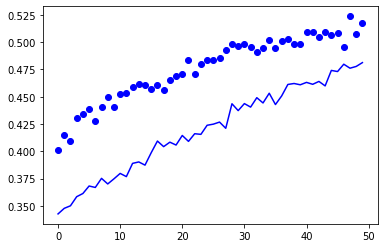

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], "b")
plt.plot(history.history["val_accuracy"], "bo")

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))
print("Test loss: {}".format(test_loss))

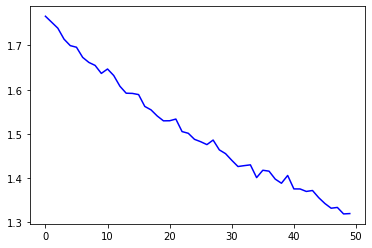

In [46]:
plt.plot(history.history["loss"], "b")

In [43]:
# Save model
from keras.models import model_from_json
from pathlib import Path

model_structure = model.to_json()
f = Path("drive/MyDrive/DeepLearning_Dataset/model_2_pretrained_structure.json")
f.write_text(model_structure)

model.save_weights("drive/MyDrive/DeepLearning_Dataset/model_2_pretrained_weights.h5")

# Tests


L'image est du courant: Pop Art

----------- Analyse par le modèle -----------

1/1 [==============================] - 0s 22ms/step
[3.3700333e-03 1.9526342e-02 5.1591387e-03 1.3542444e-07 1.6206465e-04
 9.0054911e-01 1.3275626e-05 3.0051672e-01 3.4150782e-01]
[5 8 7]
Courant artistique Top 1 Pop Art - Likelihood: 0.900549
Courant artistique Top 2 Néo-classicisme - Likelihood: 0.341508
Courant artistique Top 3 Maniérisme - Likelihood: 0.300517


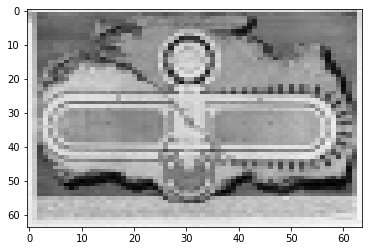

In [60]:
import keras
import numpy as np
import random as rd

from matplotlib import pyplot as plt
import cv2

## PENSER à sauvegarder un modèle sympa pour le tester

class_labels = [
    "Impressionisme",
    "Surréalisme",
    "Cubisme",
    "Baroque",
    "Divisionisme",
    "Pop Art",
    "Expressionisme",
    "Maniérisme",
    "Néo-classicisme"
]

value = rd.randint(0, len(x_test))
plt.imshow(x_test[value], interpolation='nearest', aspect='auto')

print("\nL'image est du courant: " + class_labels[y_test[value]])


print("\n----------- Analyse par le modèle -----------\n")
image_to_test = keras.utils.img_to_array(x_test[value])
# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
list_of_images = np.expand_dims(image_to_test, axis=0)
# Make a prediction using the model
results = model.predict(list_of_images)
# Since we are only testing one image, we only need to check the first result
single_result = results[0]
print(single_result)
# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
top_3_classes = np.argsort(-single_result)[:3]
print(top_3_classes)
# Print the result
print("Courant artistique Top 1 {} - Likelihood: {:2f}".format(class_labels[top_3_classes[0]], single_result[top_3_classes[0]]))
print("Courant artistique Top 2 {} - Likelihood: {:2f}".format(class_labels[top_3_classes[1]], single_result[top_3_classes[1]]))
print("Courant artistique Top 3 {} - Likelihood: {:2f}".format(class_labels[top_3_classes[2]], single_result[top_3_classes[2]]))
     